In [11]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import deepthought, mne, os

from deepthought.util.logging_util import configure_custom
configure_custom(debug=False)
mne.set_log_level('WARNING') # fewer log messages; for more change to INFO or DEBUG

subjects = ['P01','P04','P06','P07','P09','P11','P12','P13','P14']
# subjects = ['P01']

sfreq = 64.0

In [12]:
raw_cache = dict()
events_cache = dict()
meta_cache = dict()

In [13]:
from deepthought.experiments.bcmi2015.preprocessing import load_and_preprocess_raw
from deepthought.datasets.openmiir.metadata import load_stimuli_metadata, get_stimuli_version

for subject in subjects:
    if subject in raw_cache: continue
        
    stimuli_version = get_stimuli_version(subject)
    meta = load_stimuli_metadata(version=stimuli_version)
    meta_cache[subject] = meta
    
    raw, trial_events, beat_events = load_and_preprocess_raw(subject, 
                                                             sfreq=sfreq, 
                                                             interpolate_bad_channels=True,
                                                             reference_mastoids=True,
                                                             verbose=False)
    raw_cache[subject] = raw
    events_cache[subject] = trial_events

Loading raw data for subject "P01" from /imaging/deepthought/datasets/OpenMIIR/eeg/mne/P01-raw.fif
Interpolating bad channels: [u'P8', u'P10', u'T8']
Applying filter: low_cut_freq=0.5 high_cut_freq=30
Resampling 69 channels...
Excluding ICA components: [0, 1, 3, 11]
Loading raw data for subject "P04" from /imaging/deepthought/datasets/OpenMIIR/eeg/mne/P04-raw.fif
Interpolating bad channels: [u'T8']
Applying filter: low_cut_freq=0.5 high_cut_freq=30
Resampling 69 channels...
Excluding ICA components: [0, 2]
Loading raw data for subject "P06" from /imaging/deepthought/datasets/OpenMIIR/eeg/mne/P06-raw.fif
Interpolating bad channels: [u'Iz', u'FT7']
Applying filter: low_cut_freq=0.5 high_cut_freq=30
Resampling 69 channels...
Excluding ICA components: [0, 7, 11]
Loading raw data for subject "P07" from /imaging/deepthought/datasets/OpenMIIR/eeg/mne/P07-raw.fif
Applying filter: low_cut_freq=0.5 high_cut_freq=30
Resampling 69 channels...
Excluding ICA components: [0, 2]
Loading raw data for s

In [14]:
from deepthought.datasets.openmiir.epochs import get_trial_epochs
from deepthought.datasets.openmiir.metadata import load_stimuli_metadata, get_stimuli_version
from deepthought.experiments.bcmi2015.tempo_prediction import sliding_window_tempo_analysis

def compute_sliding_window_tempo_analysis_error(subject, cond, stim_id, tno, mode, verbose=False):
    
    HOP_SIZE = 5
    WINDOW_LENGTH = int(np.ceil(2.5*sfreq))
    # MAX_LENGTH = int(np.floor(6.8*sfreq)) # NOTE: shortest trial is 6.8709s
    MAX_LENGTH = int(np.floor(20*sfreq)) # NOTE: shortest trial is 6.8709s

#     stimuli_version = get_stimuli_version(subject)
#     meta = load_stimuli_metadata(version=stimuli_version)
    meta = meta_cache[subject]
    
    trials = get_trial_epochs(raw_cache[subject], events_cache[subject], 
                              stim_id=stim_id, condition=cond, 
                              subject=subject, meta=meta, include_cue=False)

    if tno == 'all':
        trial = trials.get_data()
        trial = np.asarray(trial).mean(axis=1)
    else:
        trial = trials.get_data()[tno]
    trial = trial.squeeze()
#     print trial.shape
    
    # use measured values instead of imprecise approx_bar_length
    #     gt_bar_step = meta[stim_id]['approx_bar_length'] * sfreq
    #     gt_beat_step = gt_bar_step / meta[stim_id]['beats_per_bar']
    #     gt_bpm = meta[stim_id]['bpm'] / float(meta[stim_id]['beats_per_bar'])
    gt_beat_tempo = float(meta[stim_id]['bpm'])
    gt_bar_tempo = float(gt_beat_tempo) / meta[stim_id]['beats_per_bar']
        
    skip_samples = 0
    max_samples = trial.shape[-1]
    max_samples = min(max_samples, MAX_LENGTH) 
    
    x = np.arange(24, 121, 1) # bar tempo range
    
    best, im, best_pairs, best_scores = sliding_window_tempo_analysis(
        trial, sfreq, 
        min(x), max(x), 
        skip_samples, max_samples, 
        WINDOW_LENGTH, HOP_SIZE, 
        mode=mode, verbose=verbose)

    if verbose:
        print 'best pair: {:.2f} {:.2f}'.format(*best)
        if gt_bar_tempo is not None:
            print 'expected:  {:.2f} {:.2f}'.format(gt_bar_tempo, gt_beat_tempo)


    def compute_errors(estimation):
        tempo_error = np.abs(gt_bar_tempo - estimation)

        tempo_octave_error = tempo_error
        for factor in [0.5, 2]:
            tempo_octave_error = min(tempo_octave_error, np.abs(factor*gt_bar_tempo - estimation))

        return [tempo_error, tempo_octave_error]

    errors = [] + compute_errors(best[0]) + compute_errors(best[1])
    if verbose:
        print 'errors:', errors
    return np.asarray(errors), best[0]

print compute_sliding_window_tempo_analysis_error('P01', 2, 1, 0, mode='median', verbose=True)

mean: 37
median: 36
mode: 32
max: 34
best pair: 72.00 36.00
expected:  71.00 213.00
errors: [1.0, 1.0, 35.0, 0.5]
(array([  1. ,   1. ,  35. ,   0.5]), 72)


In [15]:
from deepthought.datasets.openmiir.metadata import STIMULUS_IDS

## aggregate performance by trial
# structure: [subject, condition, stimulus, trial, scores]
def get_error_matrix(
            subjects=subjects,
            conditions=[1,2,3],
            mode='median'):

    N_TRIALS = 5
    error_matrix = np.empty((len(subjects), len(conditions), len(STIMULUS_IDS), N_TRIALS, 4))
    predictions_matrix = np.empty((len(subjects), len(conditions), len(STIMULUS_IDS), N_TRIALS))

    for p, subject in enumerate(subjects):
        for c, cond in enumerate(conditions):
            for s, stim_id in enumerate(STIMULUS_IDS):
                for tno in range(5):
                    error, tempo = compute_sliding_window_tempo_analysis_error(
                        subject=subject,
                        cond=cond,
                        stim_id=stim_id,
                        tno=tno,
                        mode=mode,
                        verbose=False)
                    
                    error_matrix[p,c,s,tno,:] = error
                    predictions_matrix[p,c,s,tno] = tempo
                    
    return error_matrix, predictions_matrix

In [16]:
def print_performance(error_matrix):
    for p, subject in enumerate(subjects):
        print '====', subject, '===='
        for s, stim_id in enumerate(STIMULUS_IDS):
    #         agg = []
    #         for c, cond in enumerate(conditions):
    #             agg.append(error_matrix[p,c,s,:,:].mean(axis=0))
    # #             print error_matrix[p,c,s,:,:]
    # #             print error_matrix[p,c,s,:,:].mean(axis=0)
    #         agg = np.asarray(agg)
    #         print stim_id, agg[:,1] 
            print stim_id, error_matrix[p,:,s,:,:].mean(axis=1)[:,1]
        print 'mean', error_matrix[p,:,:,:,:].mean(axis=1).mean(axis=1)[:,1]
    
    print 'mean', np.swapaxes(error_matrix[:,:,:,:,1].mean(axis=(0,3)),0,1).flatten()
    print error_matrix.shape

In [17]:
def plot_error_stats(error_matrix):
    # fig = plt.figure(1, figsize=(7, 3), dpi=600)
    fig = plt.figure(1, figsize=(15, 5), dpi=300)
    # fig = plt.figure(1, figsize=(12, 4), dpi=300)

    meta = load_stimuli_metadata(version=2) # use newer metadata version
    x_labels = [];
    for stim_id in STIMULUS_IDS:
        x_labels.append('{} ({})'.format(stim_id, int(meta[stim_id]['bpm']/meta[stim_id]['beats_per_bar'])))
    print x_labels 

    # Create an axes instance
    ax = fig.add_subplot(111)

    #     plt.setp('xtickNames', rotation=45, fontsize=13)
    # ax.set_xticklabels(x_labels,rotation=45, fontsize=13)
    # ax.set_xticks(np.arange(2, 36, 3))
    # ax.xaxis.set_ticks(np.arange(3.5, 36, 3))
    major_ticks = np.arange(3.5, 36, 1) 
    ax.set_xticks(major_ticks)
    # ax.set_xticklabels(STIMULUS_IDS, fontsize=13)

    #     ax.text(0, 2, '* \'fast\' group')

    # plt.ylim(*ylim)
    plt.xlabel('stimuli (conditions 1-3) and approximate bar tempo in BPM', fontsize=16)
    plt.ylabel('mean absolute error (BPM)', fontsize=16)

    # swap p and s axes
    data = np.swapaxes(error_matrix[:,:,:,:,1], 2, 0)
    data = data.reshape((np.prod(data.shape[:2]), np.prod(data.shape[2:])))
    positions = np.arange(1, 48, 1)
    positions = positions[np.where(positions % 4 > 0)]
    print positions.shape

    print data.shape     

    # Create the boxplot
    bp = ax.boxplot(data.T, positions=positions)

    # # function for setting the colors of the box plots pairs
    # def setBoxColors(bp):
    #     setp = plt.setp
    # #     for i in range(1,47,4):
    #     for i in [0]:
    #         setp(bp['boxes'][i], color='blue')
    #         setp(bp['caps'][i], color='blue')
    #         setp(bp['caps'][i], color='blue')
    #         setp(bp['whiskers'][i], color='blue')
    #         setp(bp['whiskers'][i], color='blue')
    #         setp(bp['fliers'][i], color='blue')
    #         setp(bp['fliers'][i], color='blue')
    #         setp(bp['medians'][i], color='blue')

    #     setp(bp['boxes'][1], color='red')
    #     setp(bp['caps'][2], color='red')
    #     setp(bp['caps'][3], color='red')
    #     setp(bp['whiskers'][2], color='red')
    #     setp(bp['whiskers'][3], color='red')
    #     setp(bp['fliers'][2], color='red')
    #     setp(bp['fliers'][3], color='red')
    #     setp(bp['medians'][1], color='red')
    # setBoxColors(bp)

    ax.set_xticklabels(x_labels, fontsize=13)
    ax.set_xticks(np.arange(2,47,4))
    # ax.set_xticks([]) 

    # Remove color bar tick lines, while keeping the tick labels
    xtks = plt.getp(ax.axes, 'xticklines')
    plt.setp(xtks, visible=False)

    # Remove grid lines (dotted lines inside plot)
    ax.grid(False)
    # Remove plot frame
    # ax.set_frame_on(False)
    
    # Pandas trick: remove weird dotted line on axis
    ax.lines[0].set_visible(False)

    # Customize y tick labels
    ax.tick_params(axis='y', labelsize=13)
    # yticks = [item.get_text() for item in ax.get_yticklabels()]
    # print yticks
    # ax.set_yticklabels(yticks, fontsize=13)

    # ax.yaxis.set_tick_params(pad=12)  

    # Save the figure
    # fig.savefig('plots/tempo-error-per-stim-cond.pdf', bbox_inches='tight')
    

In [19]:
all_errors_median, all_predictions_median = get_error_matrix(mode='median') # this will take a while

In [20]:
print_performance(all_errors_median)

==== P01 ====
1 [ 3.2  4.4  3.3]
2 [ 8.4  8.   7.6]
3 [ 10.2  10.4  12.2]
4 [ 4.  2.  4.]
11 [ 5.2         4.06666667  2.2       ]
12 [ 10.2          8.16666667   8.16666667]
13 [ 11.8  10.8  16.4]
14 [ 2.6  3.8  2.8]
21 [ 12.03333333   9.5          7.2       ]
22 [ 13.06666667   9.53333333  10.93333333]
23 [ 11.   14.    9.8]
24 [ 3.6  4.   5.2]
mean [ 7.94166667  7.38888889  7.48333333]
==== P04 ====
1 [ 6.   5.5  3.5]
2 [  9.6   9.8  10.3]
3 [ 16.6  12.8  14.2]
4 [ 1.4  4.6  3.4]
11 [ 6.6         5.          6.13333333]
12 [ 12.43333333  11.2          8.16666667]
13 [  8.8  13.8   8.6]
14 [ 3.   3.6  3.8]
21 [ 12.16666667  13.56666667  12.2       ]
22 [ 13.6  11.6  12.4]
23 [ 10.4  13.   12.8]
24 [ 2.6  5.4  7.2]
mean [ 8.6         9.15555556  8.55833333]
==== P06 ====
1 [  9.6  13.7  10.3]
2 [ 15.8  16.2  16.5]
3 [  9.6   8.6  13.6]
4 [ 3.6  5.2  3.2]
11 [ 10.06666667  11.           8.2       ]
12 [ 12.03333333  13.66666667  13.43333333]
13 [ 11.6   7.2  11.8]
14 [ 1.   5.6  5.4]
2

['1 (70)', '2 (63)', '3 (50)', '4 (40)', '11 (70)', '12 (63)', '13 (50)', '14 (40)', '21 (59)', '22 (55)', '23 (26)', '24 (35)']
(36,)
(36, 45)


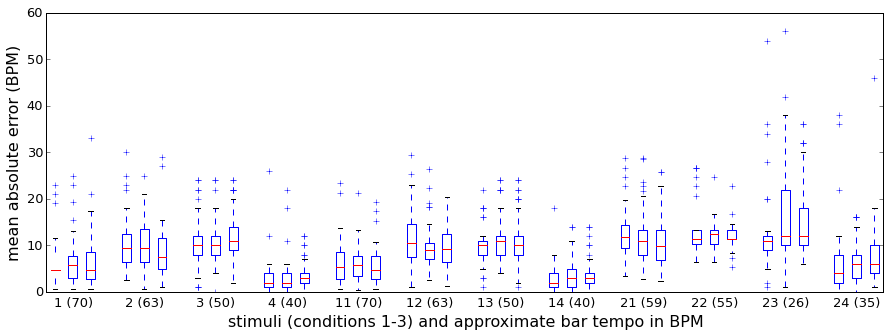

In [21]:
plot_error_stats(all_errors_median)